In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)


# Part 1: Exploratory Data Analysis

objective: to visualize user longin_time trends that best characterize the underlying patterns of demand

### Import the Data & Convert to Date Time

In [16]:
# Load the logins data
logins = pd.read_json('logins.json')
print(logins.head())

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21


In [17]:
print(logins.columns)

logins.info()

Index(['login_time'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [18]:
# Convert to datetime
logins['login_time'] = pd.to_datetime(logins['login_time'])
#Set dt column as index
logins.set_index('login_time', inplace=True)
# Resample into 15-minute intervals and count the logins 
logins_resampled = logins.resample('15min').size()
# Check the result logins_resampled.head()
print(logins_resampled.head())

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15min, dtype: int64


In [19]:
logins_resampled.info()

#logins_resampled is a series

<class 'pandas.core.series.Series'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15min
Series name: None
Non-Null Count  Dtype
--------------  -----
9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


In [20]:
#converting logins_resampled to df

df_logins_resampled = logins_resampled.to_frame(name='login_count')
print(df_logins_resampled.head())
print(df_logins_resampled.tail())

                     login_count
login_time                      
1970-01-01 20:00:00            2
1970-01-01 20:15:00            6
1970-01-01 20:30:00            9
1970-01-01 20:45:00            7
1970-01-01 21:00:00            1
                     login_count
login_time                      
1970-04-13 17:45:00            5
1970-04-13 18:00:00            5
1970-04-13 18:15:00            2
1970-04-13 18:30:00            7
1970-04-13 18:45:00            6


In [21]:
df_logins_resampled.describe()

,login_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [22]:
df_logins_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   login_count  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


### Visualize Trends

In [23]:
average_login_count=df_logins_resampled['login_count'].mean()

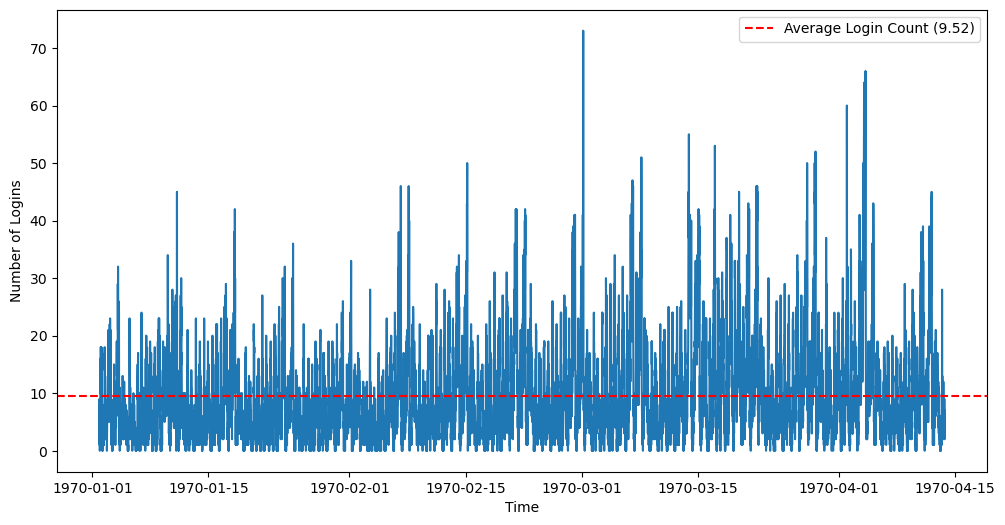

In [24]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df_logins_resampled.index, y='login_count', data=df_logins_resampled)
plt.axhline(y=average_login_count, color='red', linestyle ='--',label=f'Average Login Count ({average_login_count:.2f})')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.legend()
plt.show()

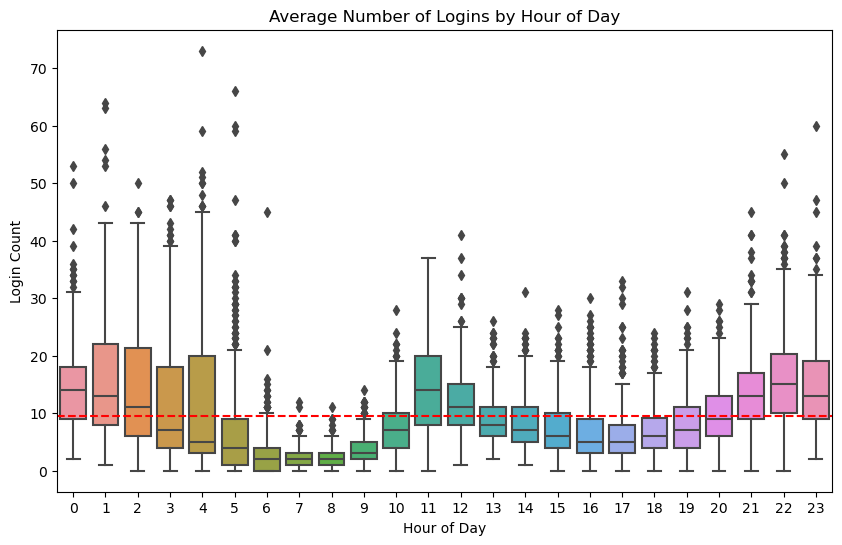

In [36]:
# Average number of logins by hour of the day
plt.figure(figsize=(10,6))
sns.boxplot(x='hour',y='login_count',data=df_logins_resampled)
plt.title('Average Number of Logins by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Login Count')
plt.axhline(y=average_login_count,color='red',linestyle='--',label=f'Average Login Count ({average_login_count:.2f})')
plt.show()

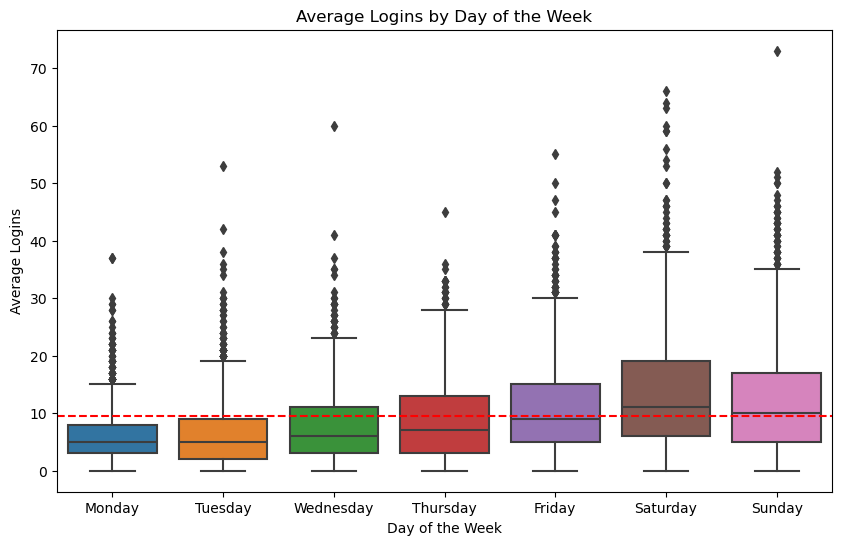

In [26]:
#Average Logins by Day of the Week

# Extract the day of the week from the index
df_logins_resampled['day_of_week'] = df_logins_resampled.index.dayofweek  
df_logins_resampled['hour']=df_logins_resampled.index.hour
# Group by day of the week and calculate the average number of logins
daily_avg = df_logins_resampled.groupby('day_of_week')['login_count'].mean()

# Plot the average logins by day of the week
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='login_count',data= df_logins_resampled)
plt.title('Average Logins by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Logins')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.axhline(y=average_login_count, color='red', linestyle='--')           
plt.show()




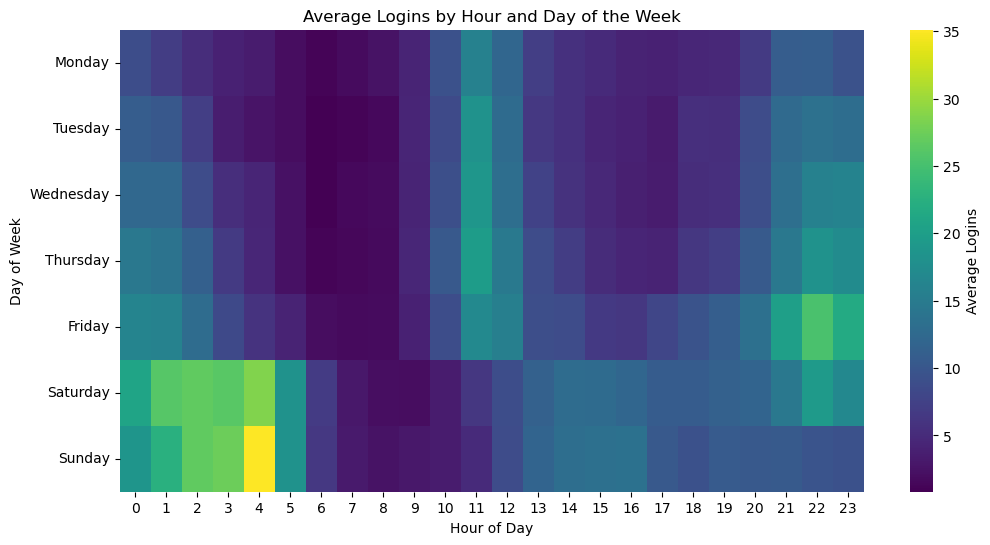

In [44]:
# Extract day of the week and hour for each login entry
df_logins_resampled['day_of_week'] = df_logins_resampled.index.dayofweek
df_logins_resampled['hour'] = df_logins_resampled.index.hour

# Group by day of the week and hour 
heatmap_data = df_logins_resampled.groupby(['day_of_week', 'hour'])['login_count'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': 'Average Logins'})
plt.title('Average Logins by Hour and Day of the Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')

# Set labels
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.yticks(ticks=np.arange(len(days)) + 0.5, labels=days, rotation=0)

plt.show()


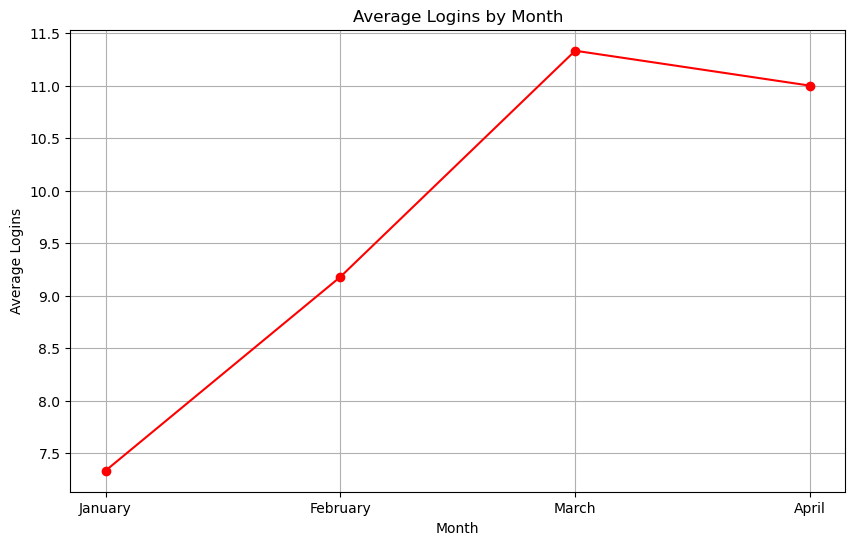

In [41]:
#Average Logins by Month

# Extract the month from the index
df_logins_resampled['month'] = df_logins_resampled.index.month

# Group by month and calculate the average number of logins
monthly_avg = df_logins_resampled.groupby('month')['login_count'].mean()

# Plot the average logins by month
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg, marker='o', linestyle='-', color='r')
plt.title('Average Logins by Month')
plt.xlabel('Month')
plt.ylabel('Average Logins')
plt.grid(True)


# Set custom month labels
months = ['January', 'February', 'March', 'April']
plt.xticks(ticks=range(1, 5), labels=months)

plt.show()





## Findings



The analysis revealed an average login count of 9.52 over the four-month span, with a steady increase in average monthly logins over time. Daily login averages were similar, with an average of 10 logins per day. Saturdays and Sundays emerged as the days with the highest login counts. A heatmap and box plot were created to highlight the time-of-day patterns for logins. The data shows peak activity from midnight to 4:00 am on weekends, likely indicating late-night demand. Another consistent peak occurred around 11:00 am, suggesting a possible lunch-hour surge. These insights point to both weekend and midday times as high-demand periods for logins.

# Part 2: Experiment & Metrics Design

The goal of Part 2 is to design an experiment that measures the success of reimbursing toll costs for driver partners between Gotham and Metropolis.

##### Key Measure of Success

##### Key Metric: 
- The primary measure of success would be the increase in the number of cross-city trips made by drivers. This metric is directly related to the goal of encouraging drivers to serve both cities, as more cross-city trips would indicate that drivers are taking advantage of the toll reimbursement.

##### Why this metric?
- The purpose of the toll reimbursement is to reduce friction (i.e., the cost of crossing the toll bridge), so the most important outcome is whether or not drivers respond by increasing their cross-city trips.

- The number of cross-city trips can be easily tracked through ride data and matched to toll bridge crossing records.

- We can measure the number of cross-city trips before and after the toll reimbursement program starts, as well as compare cross-city trip patterns between drivers who receive reimbursement and those who do not.

##### Experimental Design

We’ll use an A/B test to compare drivers who receive toll reimbursements (the experimental group) against drivers who do not (the control group).

##### Randomization: 
- Driver segmentation: Randomly assign drivers into two groups
- Group A (Experimental): Drivers who receive toll reimbursement for cross-city trips.
- Group B (Control): Drivers who do not receive toll reimbursement.
- Random assignment ensures that the two groups are comparable and that any differences in the number of cross-city  trips can be attributed to the reimbursement policy rather than other factors.

- For both groups, track the number of cross-city trips before and during the
experiment.
##### Track additional variables such as:
 -  Number of trips within each city
 -  Time of day and day of the week (since demand patterns differ)
 -  Number of trips during weekdays vs. weekends


##### Hypothesis Testing:
- Null Hypothesis (H0): Toll reimbursement does not affect the number of cross-city trips (i.e., there is no difference between Group A and Group B)
 
- Alternative Hypothesis (H1): Toll reimbursement increases the number of cross-city trips (i.e., Group A has more cross-city trips than Group B)

We can use a two-sample t-test to compare the mean number of cross-city trips between the two groups. This will help us determine if there is a statistically significant difference between the groups.

##### Test Assumptions:
- The t-test assumes normality in the distribution of cross-city trips. If the data is
not normally distributed, we can apply a non-parametric test like the
Mann-Whitney U test.
- The test also assumes homogeneity of variance between the two groups. If the
variances differ significantly, we can adjust for that using Welch's t-test.

##### Effect Size:

In addition to statistical significance, we should calculate the effect size (e.g., Cohen’s d) to determine how large the impact of the toll reimbursement is. A significant p-value might indicate a difference, but the effect size will tell us if that difference is practically meaningful.


##### Interpretation of Results and Recommendations

##### Significant Increase in Cross-City Trips:
- If the t-test shows a statistically significant increase in cross-city trips for the
experimental group (Group A) compared to the control group (Group B), we can
conclude that toll reimbursement is effective.
- Recommendation: Expand the toll reimbursement program to all drivers in both
cities to encourage cross-city rides and improve overall availability of driver
partners.
##### No Significant Difference:
- If there is no significant difference between the two groups, we can conclude that toll reimbursement does not have a measurable impact on cross-city trips.
- Recommendation: The toll reimbursement policy may not be sufficient to
incentivize drivers to travel between the cities. Additional incentives (e.g., financial bonuses for cross-city trips, enhanced route optimization) could be tested in further experiments.
##### Caveats:
- External factors: Traffic conditions, road closures, or special events could
impact the results by affecting travel between cities during the experiment period.
- Seasonality: Certain times of the year (e.g., holidays or tourist seasons) may
see higher-than-normal cross-city travel, potentially biasing the results.
- Driver behavior: Some drivers may be less willing to cross cities due to personal
preferences, which toll reimbursement alone might not overcome. Future experiments could investigate the reasons behind this reluctance.

# Part 3: Predictive Modeling for Driver Retention

#### Cleaning & EDA of Ultimate Data Challenge JSON

In [33]:
# Load the data
ultimate = pd.read_json('ultimate.json')
print(logins.head())

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   

In [34]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [35]:
ultimate.columns()

TypeError: 'Index' object is not callable